<center>
<h1><b>Revealing the Mechanism of WeChat Red Envelopes<b>
</center>

<center>
 Lei Qian 2024533134
</center>
<center>
 Jingqi Xu 2024533083
</center>
<center>
 Zihao Zhang 2024533113
</center>

<center>
date:2025/12/08 
</center>

## **1.Observation**

  To ensure the representativeness and comprehensiveness of the data, experimental scenarios with "WeChat group size" as the core variable are designed, covering two typical scales:

**3-person (small private group)**

Focus on exploring the red envelope distribution pattern in intimate, small-scale interaction scenarios. The total red envelope amount is fixed at 20 yuan, and the experiment is repeated 120 times to ensure the statistical significance of the sample.

**15-person (medium-sized social group)**

Aim to reflect the distribution characteristics in semi-public social scenarios (e.g., friend groups, interest groups). To capture the impact of different total amounts on user behavior, two types of total red envelope amounts are included to enrich the sample diversity: 

1.60 yuan per red envelope, repeated 150 times; 

2.0.6 yuan per red envelope (low-amount scenario), repeated 150 times.

## **2.Visualization**

To intuitively reveal the distribution characteristics, dispersion degree, and correlation between key variables of WeChat red envelope received amounts, this study adopts three types of visualization tools—histograms, box plots, and scatter plots—based on standardized experimental data, with plots generated using Python's matplotlib libraries. The detailed results are as follows:


#### **15-person and 60 yuan per red envelope,repeated 150 times** 

##### **1.histograms**



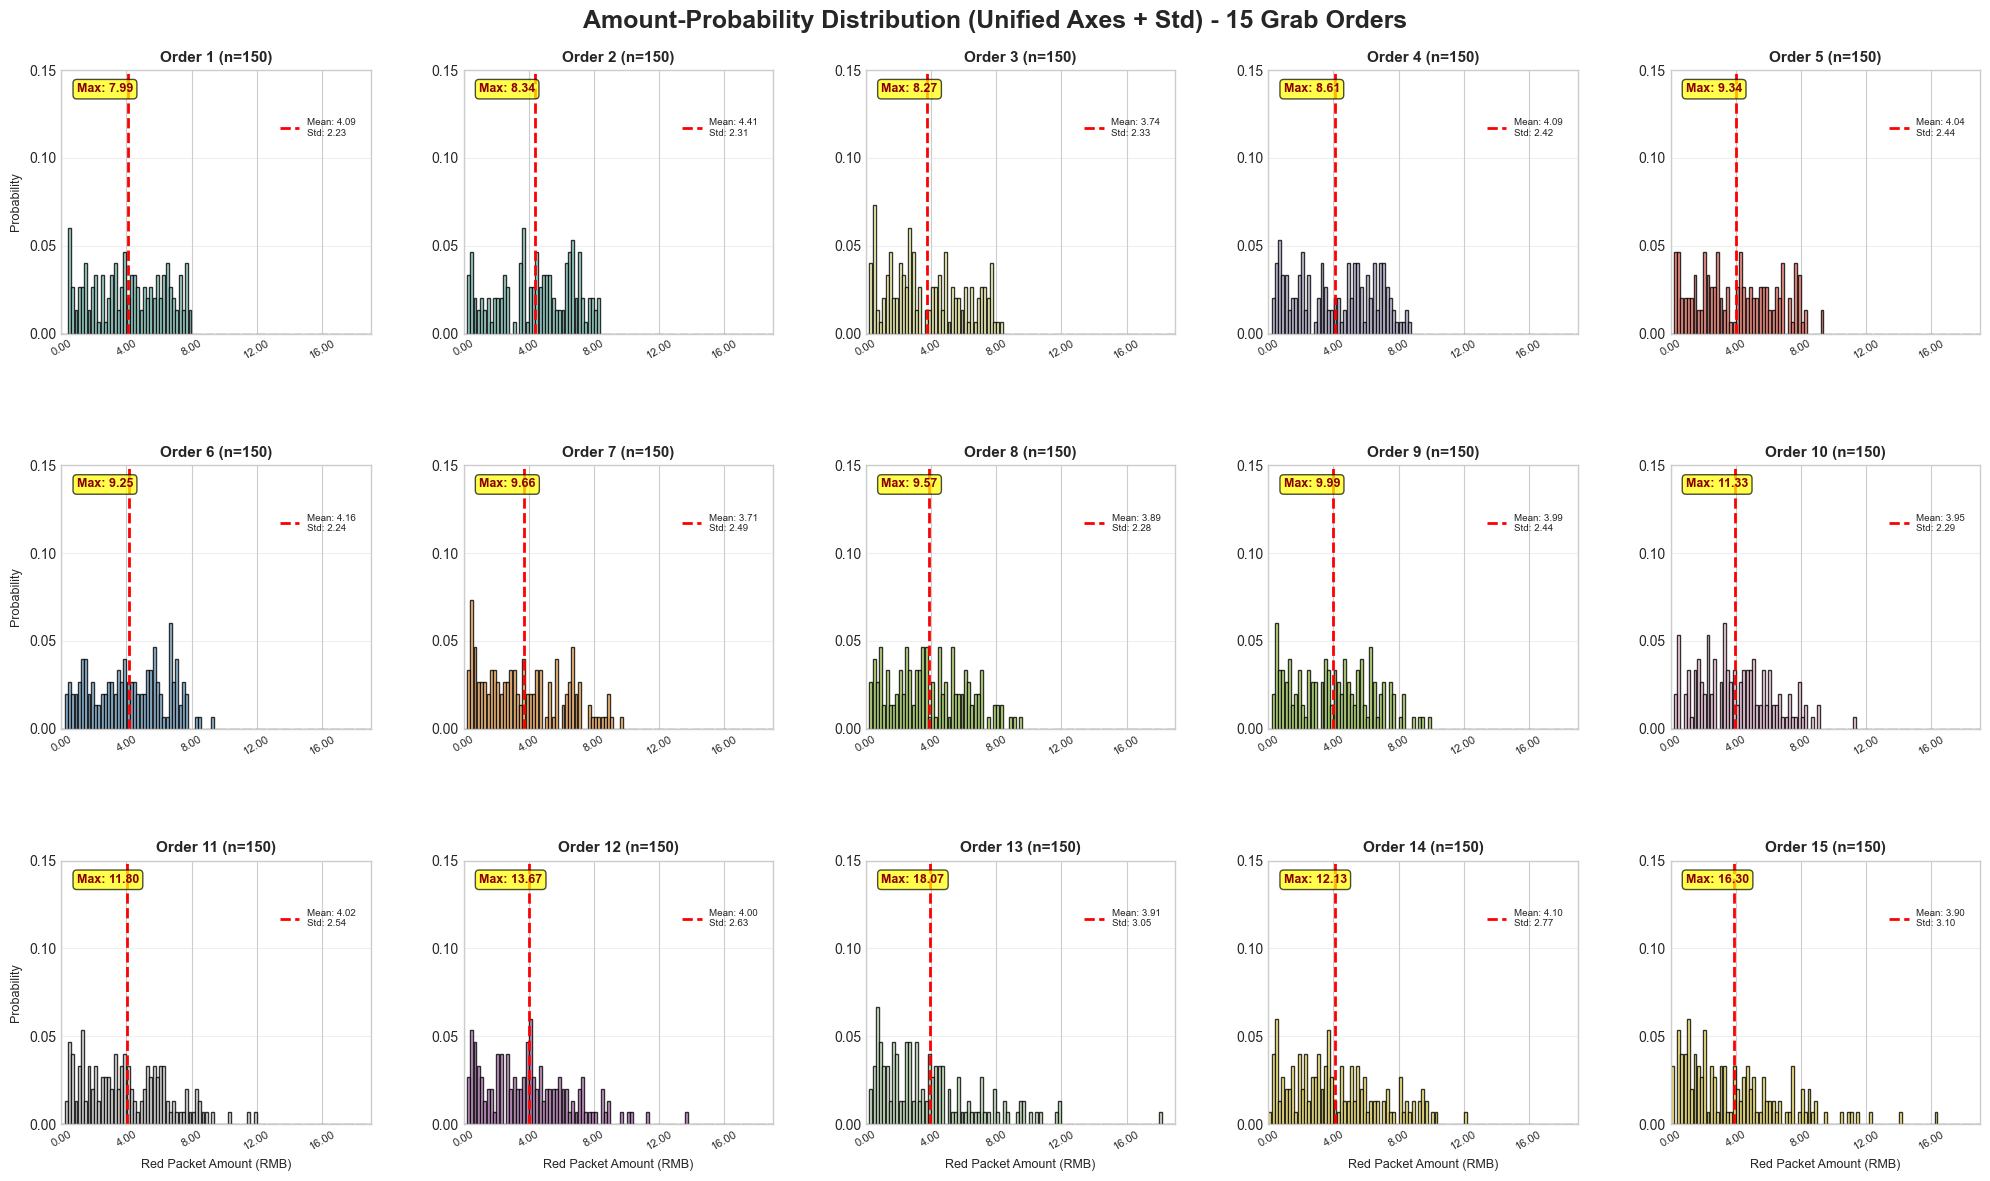

=== Key Statistics (Exact to 0.01 RMB) - 15 Grab Orders ===
Grab Order  Sample Size Mean (RMB) Std (RMB) Variance (RMB²) Max (RMB)
   Order 1          150       4.09      2.23          4.9729      7.99
   Order 2          150       4.41      2.31          5.3361      8.34
   Order 3          150       3.74      2.33          5.4289      8.27
   Order 4          150       4.09      2.42          5.8564      8.61
   Order 5          150       4.04      2.44          5.9536      9.34
   Order 6          150       4.16      2.24          5.0176      9.25
   Order 7          150       3.71      2.49          6.2001      9.66
   Order 8          150       3.89      2.28          5.1984      9.57
   Order 9          150       3.99      2.44          5.9536      9.99
  Order 10          150       3.95      2.29          5.2441     11.33
  Order 11          150       4.02      2.54          6.4516     11.80
  Order 12          150       4.00      2.63          6.9169     13.67
  Order 13       

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, MaxNLocator

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel(
    "E:/gailvlun/SI140A-proj/Data/15/15人.xls", sheet_name="Sheet1", header=None
)

grab_order_data = df.iloc[1:-1, :15].values.astype(float).round(2)
all_valid_data = grab_order_data[~np.isnan(grab_order_data)]  
global_min = np.floor(all_valid_data.min()) 
global_max = np.ceil(all_valid_data.max()) 
grab_order_labels = [f"Order {i+1}" for i in range(15)]

bin_width = 0.2
bin_edges = np.arange(global_min, global_max + bin_width, bin_width) 
bins = len(bin_edges) - 1
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle(
    "Amount-Probability Distribution (Unified Axes + Std) - 15 Grab Orders",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

colors = cm.Set3(np.linspace(0, 1, 15))

for idx, (ax, order_data, color) in enumerate(
    zip(axes.flat, grab_order_data.T, colors)
):
    valid_data = order_data[~np.isnan(order_data)].round(2)
    total_samples = len(valid_data)
    if total_samples == 0:
        ax.set_visible(False)  
        continue

    freq, _ = np.histogram(valid_data, bins=bin_edges)
    prob = freq / total_samples  
    bin_centers = bin_edges[:-1] + bin_width / 2

    order_mean = np.mean(valid_data).round(2)
    order_std = np.std(valid_data).round(2)
    order_max = np.max(valid_data).round(2)
    order_var = (order_std**2).round(4) 

    ax.bar(
        bin_centers,
        prob,
        width=bin_width - 0.02,
        edgecolor="black",
        alpha=0.8,
        color=color,
    )

    ax.axvline(
        x=order_mean,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {order_mean:.2f}\nStd: {order_std:.2f}",
    )

    ax.annotate(
        f"Max: {order_max:.2f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=9,
        fontweight="bold",
        color="darkred",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
        ha="left",
        va="top",
    )

    ax.set_xlim(global_min, global_max)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=False))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))
    ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    ax.tick_params(axis="x", which="minor", color="#cccccc", labelsize=6)
    ax.tick_params(axis="x", which="major", labelsize=8, rotation=30)

    ax.set_ylim(0, 0.15)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))  
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y:.2f}"))

    ax.set_title(
        f"{grab_order_labels[idx]} (n={total_samples})", fontsize=11, fontweight="bold"
    )
    if idx >= 10:
        ax.set_xlabel("Red Packet Amount (RMB)", fontsize=9, labelpad=5)
    if idx % 5 == 0:
        ax.set_ylabel("Probability", fontsize=9, labelpad=5)

    ax.legend(fontsize=7, loc="upper right", bbox_to_anchor=(0.98, 0.85))
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(
    top=0.93,
    hspace=0.5,  
    wspace=0.3, 
)

plt.savefig(
    "unified_axes_amount_probability_with_std.png", dpi=300, bbox_inches="tight"
)
plt.show()

print("=== Key Statistics (Exact to 0.01 RMB) - 15 Grab Orders ===")
order_stats = []
for i in range(15):
    valid_data = grab_order_data.T[i][~np.isnan(grab_order_data.T[i])].round(2)
    if len(valid_data) == 0:
        order_stats.append(
            {
                "Grab Order": f"Order {i+1}",
                "Sample Size": 0,
                "Mean (RMB)": "N/A",
                "Std (RMB)": "N/A",
                "Variance (RMB²)": "N/A", 
                "Max (RMB)": "N/A",
            }
        )
        continue
    mean_val = np.mean(valid_data).round(2)
    std_val = np.std(valid_data).round(2)
    var_val = (std_val**2).round(4)
    max_val = np.max(valid_data).round(2)
    order_stats.append(
        {
            "Grab Order": f"Order {i+1}",
            "Sample Size": len(valid_data),
            "Mean (RMB)": f"{mean_val:.2f}",
            "Std (RMB)": f"{std_val:.2f}",
            "Variance (RMB²)": f"{var_val:.4f}",
            "Max (RMB)": f"{max_val:.2f}",
        }
    )

stats_df = pd.DataFrame(order_stats)
print(stats_df.to_string(index=False))


From the graph,we can find

1. The mean amount of all grabbing orders is close to 4 RMB (the theoretical mean of 60 RMB ÷ 15 people), indicating that amounts are concentrated around the theoretical mean regardless of the grabbing order.

2. Early grabbing orders (e.g., Order1-Order5) have smaller standard deviations (2.23-2.44), with more compact amount distributions;Later grabbing orders (e.g., Order10-Order15) have slightly higher standard deviations (2.50-3.05), and their maximum amounts (e.g., Max=18.30 for Order15) are significantly higher than those of early orders, meaning dispersion increases as the grabbing order moves backward.

3. All orders show a right-skewed "dense left, sparse right" pattern—probability is higher in the low-amount range (0-8 RMB) and drops rapidly in the high-amount range, which aligns with the typical random allocation feature of red envelopes.

4. For the data that low than 0.4,there is no any distribution.From this we can suspect that there is a mechanism that force a lower limit for each red envelope.It is rational that the lower limit is related to the rest money.
5. And for each order,we can see that there is a upper limit for them.And when the order increase,the upper limit is increasing.We suspect that the upper limit is related to the rest money and rest players.

To eliminate the effect of the remaining amount, we divided the amount each person received by the current total amount, looking only at the impact of the order on the proportion of money received.

**amount each person receives/remaining amount** histogram

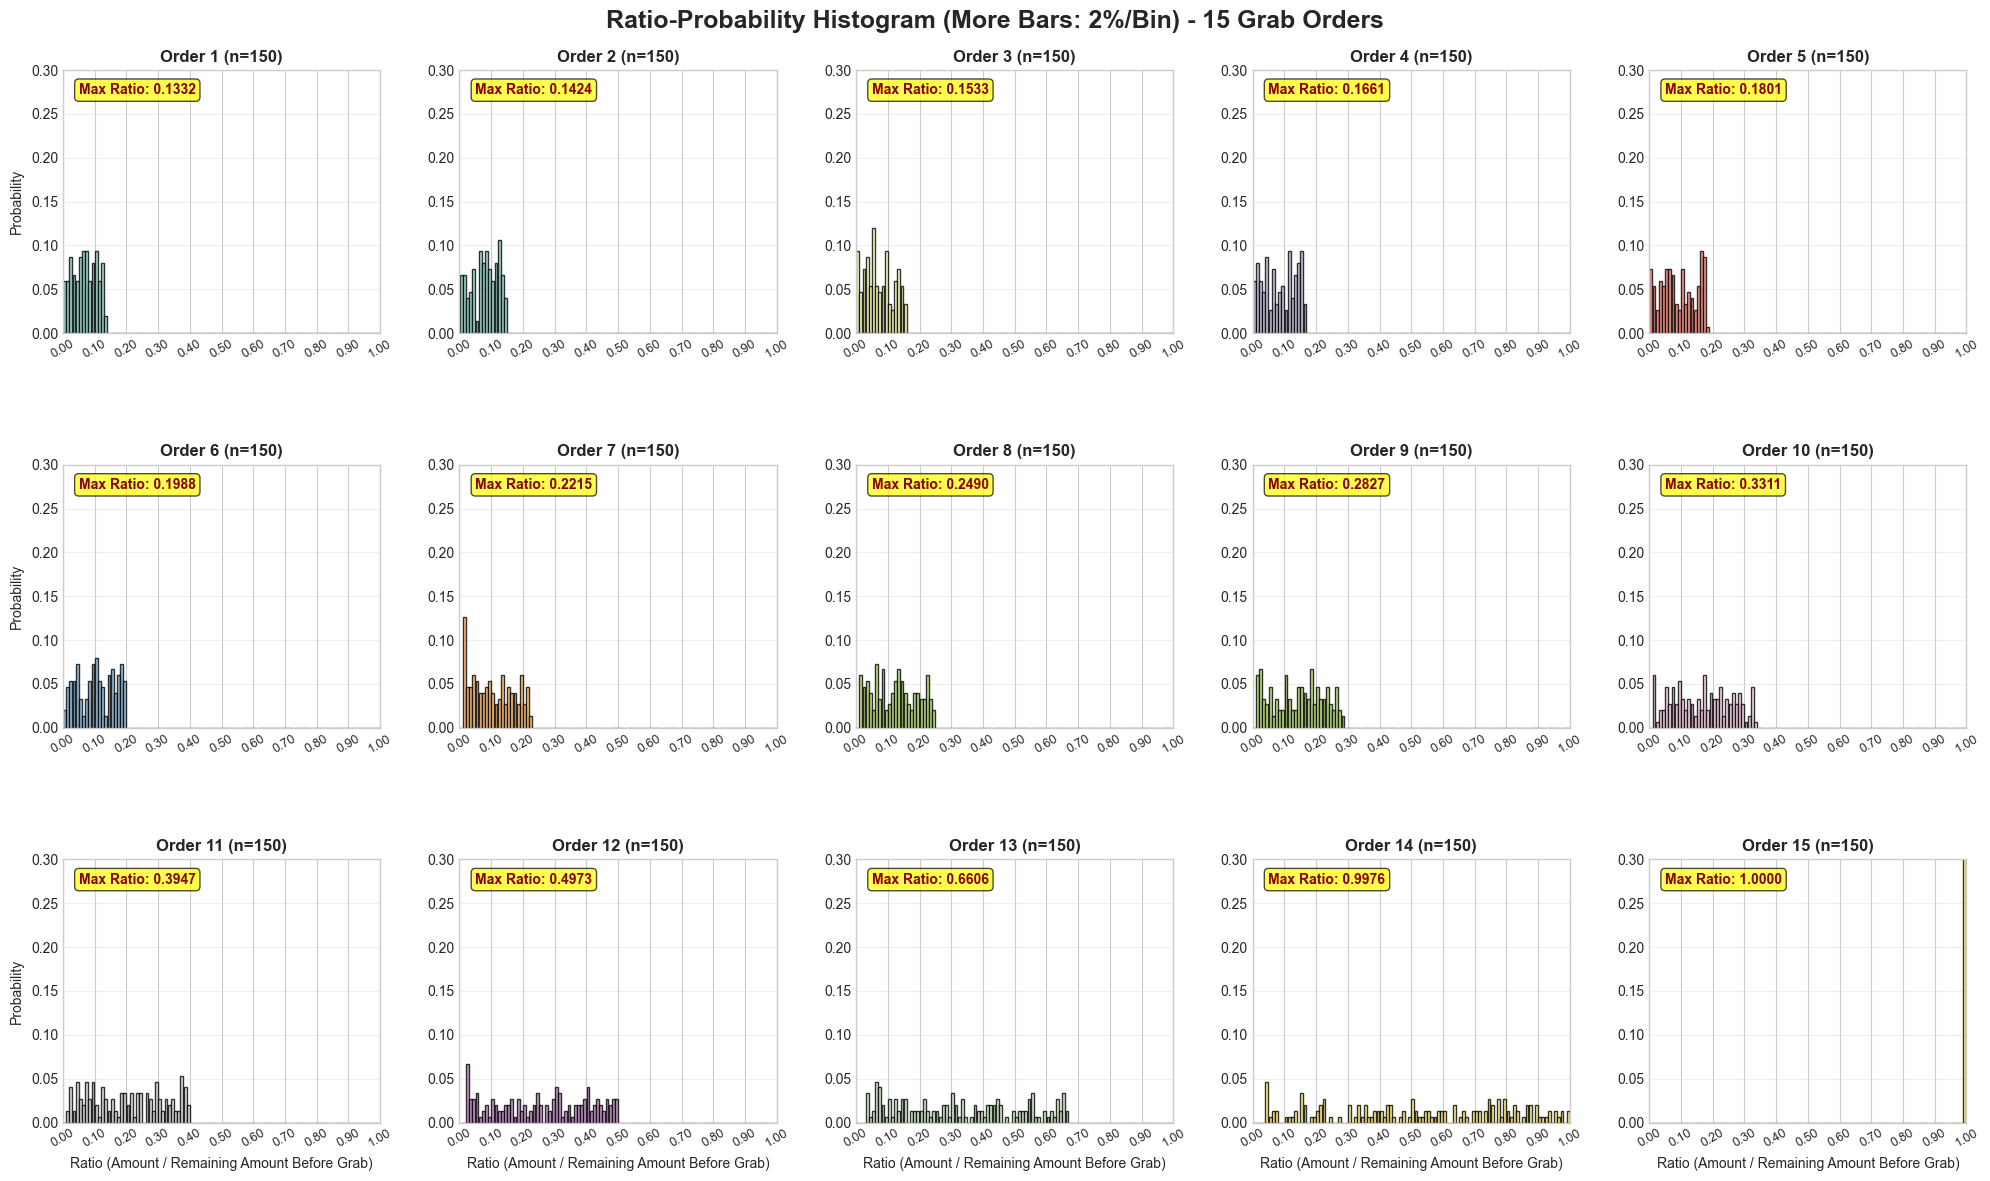

=== Key Statistics (Ratio = Amount / Remaining Amount) - 15 Grab Orders ===
Grab Order  Sample Size Mean Ratio Std Ratio Variance (Ratio²) Max Ratio
   Order 1          150     0.0681    0.0371          0.001376    0.1332
   Order 2          150     0.0788    0.0411          0.001689    0.1424
   Order 3          150     0.0726    0.0448          0.002007    0.1533
   Order 4          150     0.0857    0.0506          0.002560    0.1661
   Order 5          150     0.0926    0.0552          0.003047    0.1801
   Order 6          150     0.1064    0.0575          0.003306    0.1988
   Order 7          150     0.1038    0.0656          0.004303    0.2215
   Order 8          150     0.1219    0.0690          0.004761    0.2490
   Order 9          150     0.1418    0.0804          0.006464    0.2827
  Order 10          150     0.1671    0.0918          0.008427    0.3311
  Order 11          150     0.2027    0.1165          0.013572    0.3947
  Order 12          150     0.2571    0.1488    

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, MaxNLocator

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel(
    "E:/gailvlun/SI140A-proj/Data/15/15人.xls", sheet_name="Sheet1", header=None
)

detail_data = df.iloc[1:-1, :15].values.astype(float).round(2)
total_per_round = df.iloc[1:-1, 15].values.astype(float).round(2)
n_rounds = len(detail_data)
grab_order_labels = [f"Order {i+1}" for i in range(15)]

ratio_matrix = np.zeros_like(detail_data)
for round_idx in range(n_rounds):
    total = total_per_round[round_idx]
    remaining = total
    for order_idx in range(15):
        amount = detail_data[round_idx, order_idx]
        if np.isnan(amount) or remaining <= 0:
            ratio = np.nan
        else:
            ratio = (amount / remaining).round(4)
        ratio_matrix[round_idx, order_idx] = ratio
        remaining -= amount

all_valid_ratio = ratio_matrix[~np.isnan(ratio_matrix)]
global_min_ratio = 0.0
global_max_ratio = min(1.05, np.ceil(all_valid_ratio.max() * 10) / 10)

bin_width_ratio = 0.01 
bin_edges_ratio = np.arange(
    global_min_ratio, global_max_ratio + bin_width_ratio, bin_width_ratio
)
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle(
    "Ratio-Probability Histogram (More Bars: 2%/Bin) - 15 Grab Orders",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

colors = cm.Set3(np.linspace(0, 1, 15))

for idx, (ax, order_ratio, color) in enumerate(zip(axes.flat, ratio_matrix.T, colors)):
    valid_ratio = order_ratio[~np.isnan(order_ratio)]
    total_samples = len(valid_ratio)
    if total_samples == 0:
        ax.set_visible(False)
        continue

    freq, _ = np.histogram(valid_ratio, bins=bin_edges_ratio)
    prob = freq / total_samples
    bin_centers = bin_edges_ratio[:-1] + bin_width_ratio / 2

    ratio_mean = np.mean(valid_ratio).round(4)
    ratio_std = np.std(valid_ratio).round(4)
    ratio_max = np.max(valid_ratio).round(4)
    ratio_var = (ratio_std**2).round(6)

    ax.bar(
        bin_centers,
        prob,
        width=bin_width_ratio - 0.001, 
        edgecolor="black",
        alpha=0.8,
        color=color,
    )

    ax.annotate(
        f"Max Ratio: {ratio_max:.4f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=10,
        fontweight="bold",
        color="darkred",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
        ha="left",
        va="top",
    )

    ax.set_xlim(global_min_ratio, global_max_ratio)
    ax.xaxis.set_major_locator(
        MultipleLocator(0.1)
    )
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))
    ax.xaxis.set_minor_locator(
        MultipleLocator(bin_width_ratio)
    )
    ax.tick_params(
        axis="x", which="minor", color="#cccccc", labelsize=5
    )
    ax.tick_params(axis="x", which="major", labelsize=9, rotation=30)

    ax.set_ylim(0, 0.3) 
    ax.yaxis.set_major_locator(MultipleLocator(0.05)) 
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y:.2f}"))

    ax.set_title(
        f"{grab_order_labels[idx]} (n={total_samples})", fontsize=12, fontweight="bold"
    )
    if idx >= 10:
        ax.set_xlabel(
            "Ratio (Amount / Remaining Amount Before Grab)", fontsize=10, labelpad=5
        )
    if idx % 5 == 0:
        ax.set_ylabel("Probability", fontsize=10, labelpad=5)

    ax.grid(axis="y", alpha=0.3)


plt.tight_layout()
plt.subplots_adjust(
    top=0.93,
    hspace=0.5,
    wspace=0.25,
)

plt.savefig("dense_bars_ratio_probability.png", dpi=300, bbox_inches="tight")
plt.show()

print("=== Key Statistics (Ratio = Amount / Remaining Amount) - 15 Grab Orders ===")
order_stats = []
for i in range(15):
    valid_ratio = ratio_matrix[:, i][~np.isnan(ratio_matrix[:, i])]
    if len(valid_ratio) == 0:
        order_stats.append(
            {
                "Grab Order": f"Order {i+1}",
                "Sample Size": 0,
                "Mean Ratio": "N/A",
                "Std Ratio": "N/A",
                "Variance (Ratio²)": "N/A",
                "Max Ratio": "N/A",
            }
        )
        continue
    mean_val = np.mean(valid_ratio).round(4)
    std_val = np.std(valid_ratio).round(4)
    var_val = (std_val**2).round(6)
    max_val = np.max(valid_ratio).round(4)
    order_stats.append(
        {
            "Grab Order": f"Order {i+1}",
            "Sample Size": len(valid_ratio),
            "Mean Ratio": f"{mean_val:.4f}",
            "Std Ratio": f"{std_val:.4f}",
            "Variance (Ratio²)": f"{var_val:.6f}",
            "Max Ratio": f"{max_val:.4f}",
        }
    )

stats_df = pd.DataFrame(order_stats)
print(stats_df.to_string(index=False))


From the graph we can find:

1. The ratio upper limit of later grabbing orders (Order2-Order15) increases significantly (Order15 reaches 1.0), indicating that the later one grabs, the higher the proportion of the remaining amount a single grab can account for.

for some special case we can suspect the upper limit:**Order 11 max=0.3947**$\approx$ **0.4**;**Order 12 max=0.4973**$\approx$ **0.5**;**Order 13 max=0.6606**$\approx$ **0.6667**

so we suspect that the **upper limit is $\frac{2}{m}$**,m is the rest number of player.

2. The lower limit is also increasing along with the increase of order.

We observed that here many first-place individuals received 0.4 yuan, which is quite rare. Since 0.4 is 4 divided by 10, and 4 is the average per person, we therefore speculate that the lower limit of the data is the average divided by 10.

Moreover, the bands closest to the lower limit are usually longer, which indicates that if a player is assigned an amount below the lower limit, it is likely to be rounded up to the lower limit.We suspect that the distribution is on the **internval [0,upper limit]**

3. Ratios of all orders are uniform in the interval.It is likely that it can fit the uniform distribution.
   

##### **2.box plots**

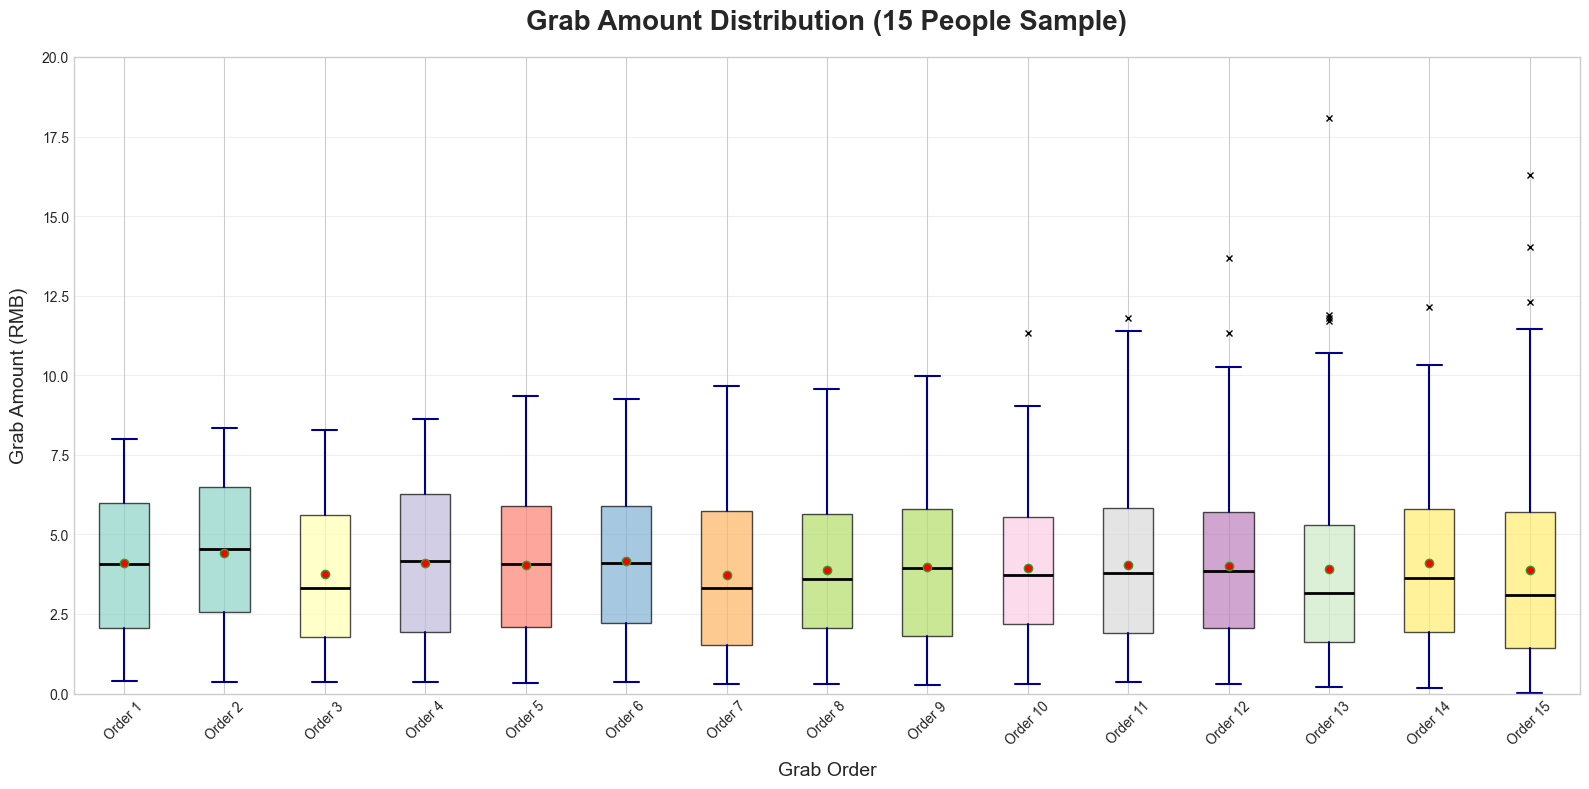

=== Boxplot Statistics of Order Amounts for 15 People ===


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel("E:/gailvlun/SI140A-proj/Data/15/15人.xls", sheet_name="Sheet1", header=None)

amount_data = df.iloc[1:-1, :15].values.astype(float).round(2)
grab_order_labels = [f"Order {i+1}" for i in range(15)] 

boxplot_data = []
for i in range(15):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    boxplot_data.append(valid_amount)

all_valid_amount = amount_data[~np.isnan(amount_data)]
global_min_amount = 0.0
global_max_amount = np.ceil(all_valid_amount.max()) if len(all_valid_amount) > 0 else 10

fig, ax = plt.subplots(figsize=(16, 8))
bp = ax.boxplot(
    boxplot_data,
    tick_labels=grab_order_labels,
    patch_artist=True, 
    showmeans=True, 
    meanprops={"marker": "o", "markerfacecolor": "red", "markersize": 6},
    medianprops={"color": "black", "linewidth": 2},
    whiskerprops={"color": "darkblue", "linewidth": 1.5},
    capprops={"color": "darkblue", "linewidth": 1.5},
    flierprops={"marker": "x", "markerfacecolor": "orange", "markersize": 5},
)

colors = plt.cm.Set3(np.linspace(0, 1, 15))
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title(
    "Grab Amount Distribution (15 People Sample)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Grab Order", fontsize=14, labelpad=10)
ax.set_ylabel("Grab Amount (RMB)", fontsize=14, labelpad=10)
ax.set_ylim(global_min_amount, global_max_amount + 1) 
ax.tick_params(axis="x", rotation=45, labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("15people_amount_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

print("=== Boxplot Statistics of Order Amounts for 15 People ===")

1.The boxes (interquartile ranges) of early grabbing orders (Order1-Order6) are relatively compact, with small amount fluctuations;

2.The boxes of later grabbing orders (Order10-Order15) widen, and their whiskers (ranges from min to max) extend significantly, with high-value outliers (e.g., the maximum of Order15 exceeds 17 RMB). This means the later one grabs, the greater the amount dispersion.

##### **3.scatter plots—based**

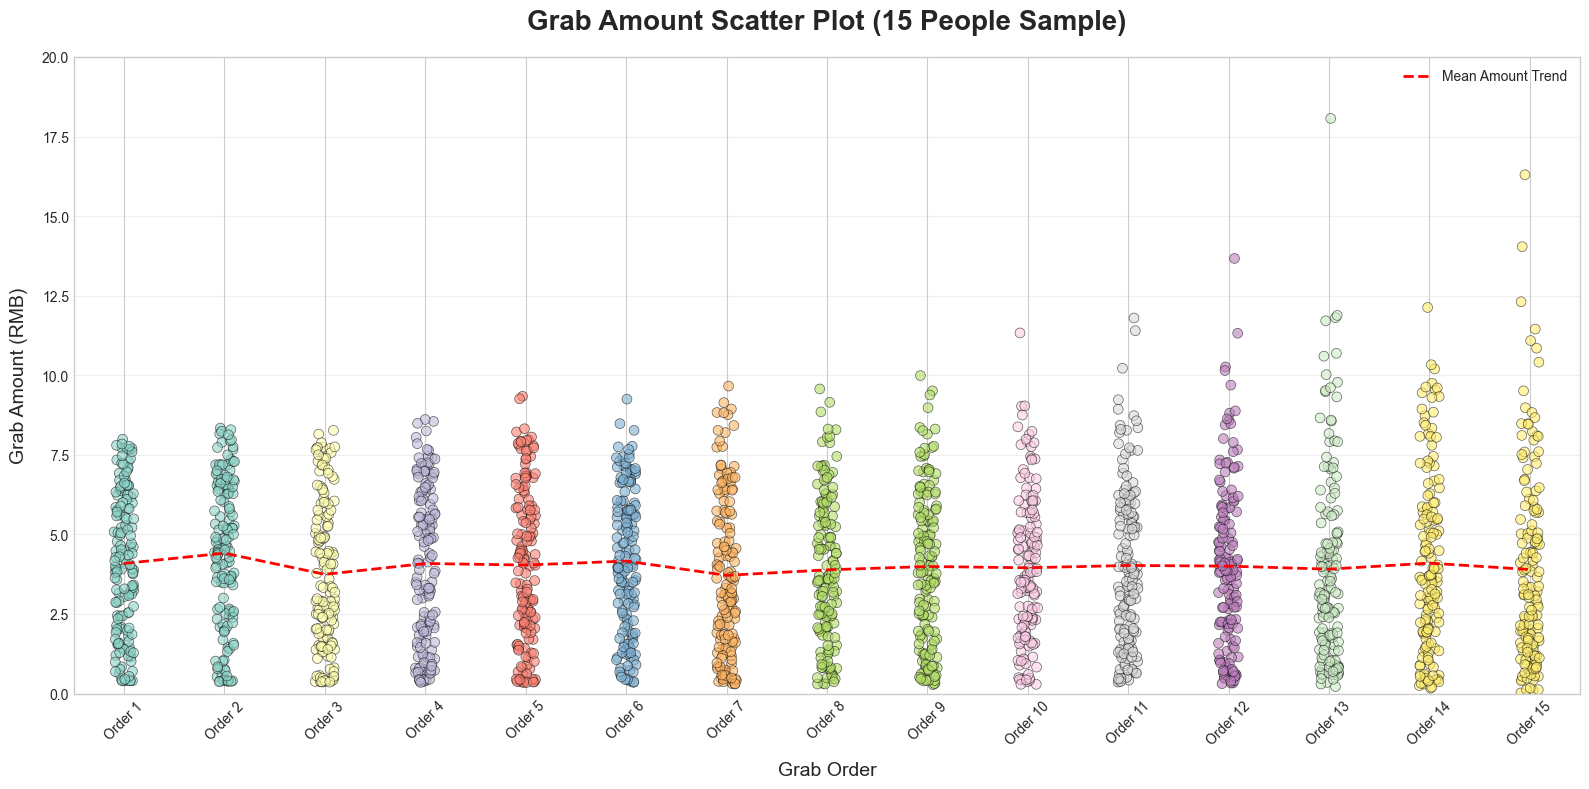

=== Trend of average order amounts for 15 people ===
Mean amount of item 1:4.09 yuan
Mean amount of item 2:4.41 yuan
Mean amount of item 3:3.74 yuan
Mean amount of item 4:4.09 yuan
Mean amount of item 5:4.04 yuan
Mean amount of item 6:4.16 yuan
Mean amount of item 7:3.71 yuan
Mean amount of item 8:3.89 yuan
Mean amount of item 9:3.99 yuan
Mean amount of item 10:3.95 yuan
Mean amount of item 11:4.02 yuan
Mean amount of item 12:4.00 yuan
Mean amount of item 13:3.91 yuan
Mean amount of item 14:4.10 yuan
Mean amount of item 15:3.90 yuan


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel("E:/gailvlun/SI140A-proj/Data/15/15人.xls", sheet_name="Sheet1", header=None)

amount_data = df.iloc[1:-1, :15].values.astype(float).round(2)
grab_order_labels = [f"Order {i+1}" for i in range(15)]

x_data = []
y_data = []
colors_list = []
colors = plt.cm.Set3(np.linspace(0, 1, 15))

for i in range(15):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    x_jitter = [i + 1 + random.uniform(-0.1, 0.1) for _ in valid_amount]
    x_data.extend(x_jitter)
    y_data.extend(valid_amount)
    colors_list.extend([colors[i]] * len(valid_amount))

all_valid_amount = amount_data[~np.isnan(amount_data)]
global_min_amount = 0.0
global_max_amount = np.ceil(all_valid_amount.max()) if len(all_valid_amount) > 0 else 10

fig, ax = plt.subplots(figsize=(16, 8))
scatter = ax.scatter(
    x_data, y_data, c=colors_list, alpha=0.6, s=50, edgecolors="black", linewidths=0.5
)

x_trend = np.arange(1, 16)
y_trend = [
    np.nanmean(amount_data[:, i][~np.isnan(amount_data[:, i])]) for i in range(15)
]
ax.plot(
    x_trend,
    y_trend,
    color="red",
    linewidth=2,
    linestyle="--",
    label="Mean Amount Trend",
)
ax.legend(fontsize=10)

ax.set_title(
    "Grab Amount Scatter Plot (15 People Sample)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Grab Order", fontsize=14, labelpad=10)
ax.set_ylabel("Grab Amount (RMB)", fontsize=14, labelpad=10)
ax.set_xlim(0.5, 15.5)
ax.set_ylim(global_min_amount, global_max_amount + 1)
ax.set_xticks(range(1, 16))
ax.set_xticklabels(grab_order_labels, rotation=45)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("15people_amount_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

print("=== Trend of average order amounts for 15 people ===")
for i in range(15):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    mean_amount = np.nanmean(valid_amount) if len(valid_amount) > 0 else np.nan
    print(f"Mean amount of item {i+1}:{mean_amount:.2f} yuan")


1. Amounts of all grabbing orders are distributed around 4 RMB (the theoretical mean of 60 RMB ÷ 15 people), and the red mean trend line remains basically stable. This indicates that regardless of the grabbing order, the overall average amount aligns with the theoretical mean.

2. Amounts of early grabbing orders (Order1-Order6) are concentrated in the 0-8 RMB range, with a compact distribution;Amounts of later grabbing orders (Order10-Order15) expand to the 0-18 RMB range, and the proportion of high-amount samples (＞10 RMB) increases significantly. Dispersion grows noticeably as the grabbing order moves backward.

3. Extreme high amounts (over 15 RMB) appear in later grabbing orders (e.g., Order13, Order15), further verifying the rule that "amount fluctuations are more intense for later grabs".

The next is the diagram of **3-person 60 yuan per red envelope for 120 times** and **15-person 0.6 yuan per red envelope for 120 times**

They reveal the same patterns as the figure above.***And these data pass the examine of our suspect to lower limit and upper limit.**

#### **3-person 60 yuan per red envelope for 120 times**

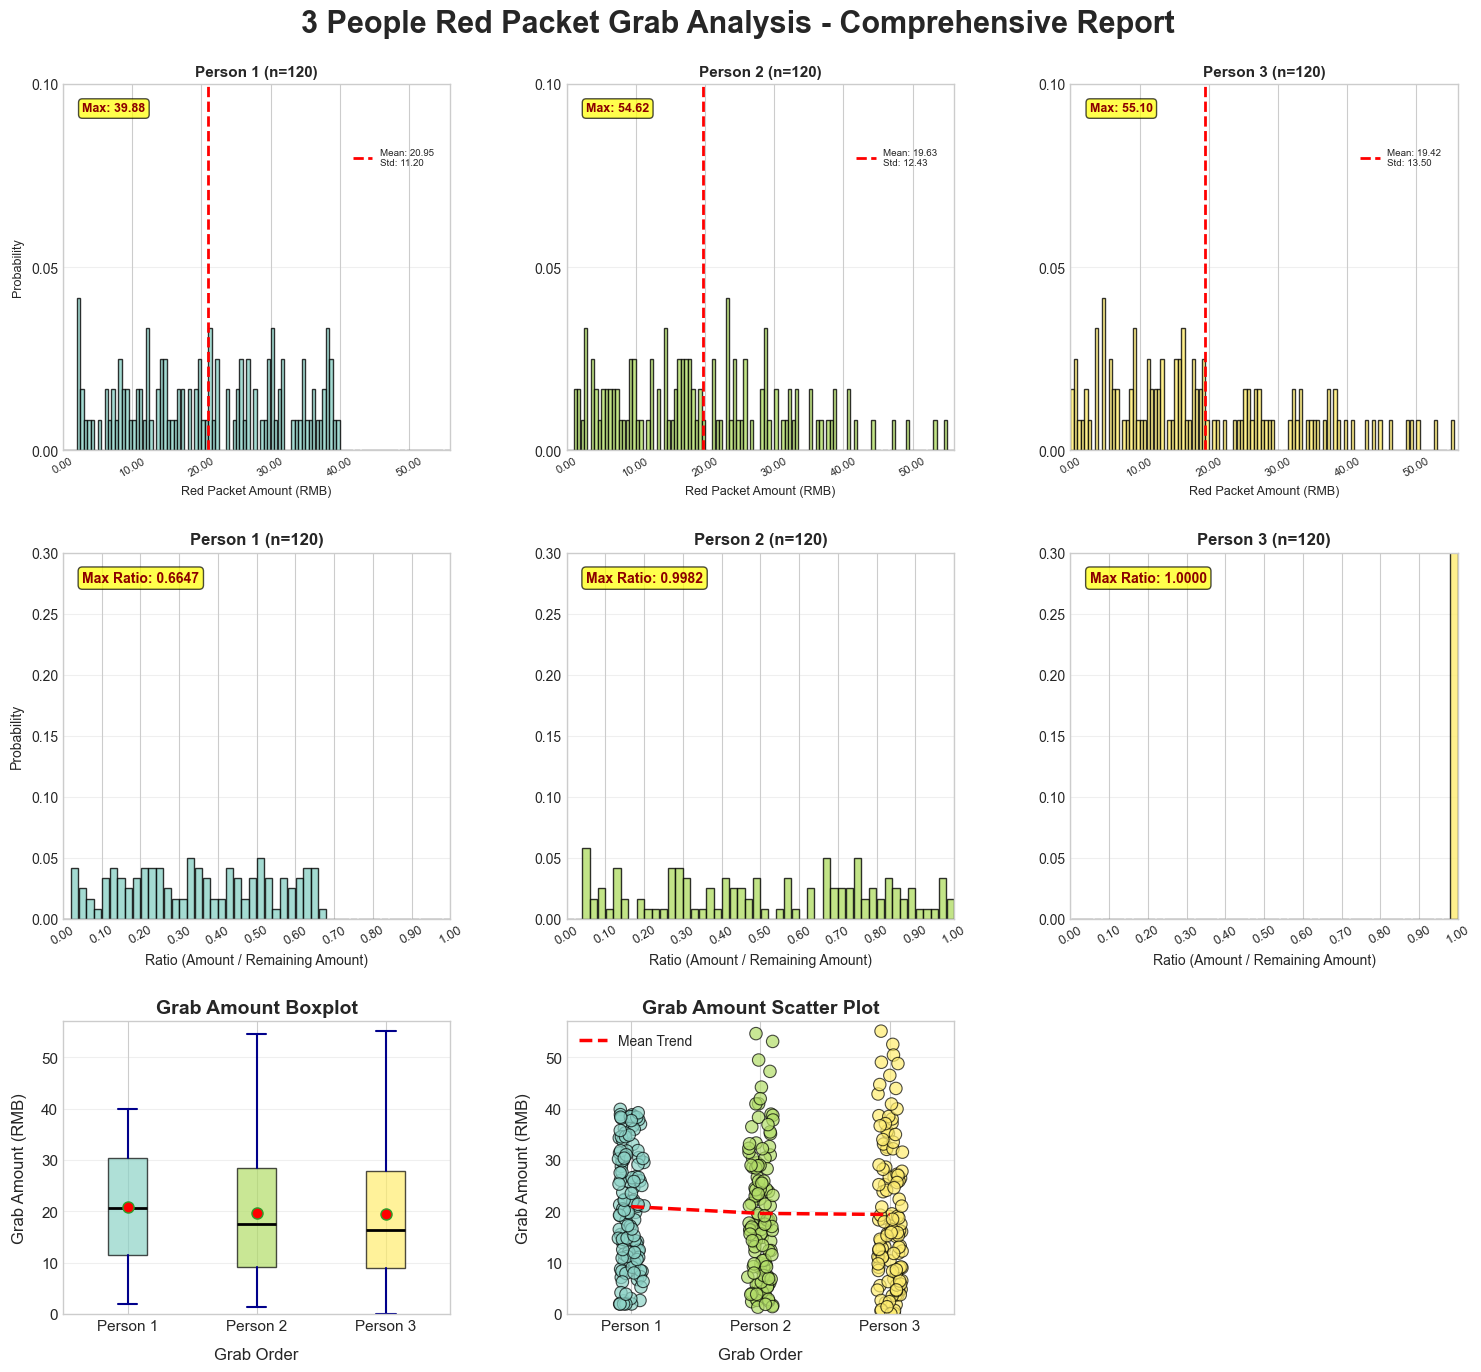

=== 3 People Red Packet Grab - Comprehensive Statistics ===

1. Amount Statistics (RMB):
  Person 1:
    - Sample Size: 120
    - Mean: 20.95
    - Median: 20.77
    - Std: 11.20
    - Min/Max: 2.00 / 39.88
  Person 2:
    - Sample Size: 120
    - Mean: 19.63
    - Median: 17.52
    - Std: 12.43
    - Min/Max: 1.36 / 54.62
  Person 3:
    - Sample Size: 120
    - Mean: 19.42
    - Median: 16.37
    - Std: 13.50
    - Min/Max: 0.10 / 55.10

2. Remaining Amount Ratio Statistics:
  Person 1:
    - Sample Size: 120
    - Mean Ratio: 0.3492
    - Max Ratio: 0.6647
    - Std Ratio: 0.1866
  Person 2:
    - Sample Size: 120
    - Mean Ratio: 0.5124
    - Max Ratio: 0.9982
    - Std Ratio: 0.2834
  Person 3:
    - Sample Size: 120
    - Mean Ratio: 1.0000
    - Max Ratio: 1.0000
    - Std Ratio: 0.0000


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, MaxNLocator
import random

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

DATA_PATH = "E:/gailvlun/SI140A-proj/Data/3/3人总.xls"
OUTPUT_PATH = "3people_comprehensive_analysis.png"

df = pd.read_excel(DATA_PATH, sheet_name="Sheet1", header=None)

amount_data = df.iloc[1:-1, :3].values.astype(float).round(2)
total_cols = df.shape[1]
if total_cols > 3:
    total_per_round = df.iloc[1:-1, -1].values.astype(float).round(2)
else:
    total_per_round = np.nansum(amount_data, axis=1).round(2)

ratio_matrix = np.zeros_like(amount_data)
n_rounds = len(amount_data)
for round_idx in range(n_rounds):
    total = total_per_round[round_idx] if not np.isnan(total_per_round[round_idx]) else 0
    remaining = total
    for order_idx in range(3):
        amount = amount_data[round_idx, order_idx]
        if np.isnan(amount) or remaining <= 0 or total <= 0 or amount < 0:
            ratio = np.nan
        else:
            ratio = (amount / remaining).round(4)
            ratio = min(ratio, 1.0)
        ratio_matrix[round_idx, order_idx] = ratio
        remaining -= amount

grab_order_labels = ["Person 1", "Person 2", "Person 3"]
colors = cm.Set3(np.linspace(0, 1, 3))
all_valid_amount = amount_data[~np.isnan(amount_data)]
global_min_amount = np.floor(all_valid_amount.min()) if len(all_valid_amount) > 0 else 0
global_max_amount = np.ceil(all_valid_amount.max()) if len(all_valid_amount) > 0 else 10

fig = plt.figure(figsize=(18, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3, height_ratios=[1, 1, 0.8], width_ratios=[1, 1, 1])

ax1_1 = fig.add_subplot(gs[0, 0])
ax1_2 = fig.add_subplot(gs[0, 1])
ax1_3 = fig.add_subplot(gs[0, 2])
amount_axes = [ax1_1, ax1_2, ax1_3]

ax2_1 = fig.add_subplot(gs[1, 0])
ax2_2 = fig.add_subplot(gs[1, 1])
ax2_3 = fig.add_subplot(gs[1, 2])
ratio_axes = [ax2_1, ax2_2, ax2_3]

ax3_1 = fig.add_subplot(gs[2, 0])
ax3_2 = fig.add_subplot(gs[2, 1])
ax3_3 = fig.add_subplot(gs[2, 2])

fig.suptitle("3 People Red Packet Grab Analysis - Comprehensive Report", fontsize=22, fontweight="bold", y=0.98)

bin_width = 0.50
bin_edges = np.arange(global_min_amount, global_max_amount + bin_width, bin_width)

for idx, (ax, color, label) in enumerate(zip(amount_axes, colors, grab_order_labels)):
    valid_data = amount_data[:, idx][~np.isnan(amount_data[:, idx])].round(2)
    total_samples = len(valid_data)
    if total_samples == 0:
        ax.set_visible(False)
        continue
    freq, _ = np.histogram(valid_data, bins=bin_edges)
    prob = freq / total_samples
    bin_centers = bin_edges[:-1] + bin_width / 2
    order_mean = np.mean(valid_data).round(2)
    order_std = np.std(valid_data).round(2)
    order_max = np.max(valid_data).round(2)
    ax.bar(bin_centers, prob, width=bin_width - 0.02, edgecolor="black", alpha=0.8, color=color)
    ax.axvline(x=order_mean, color="red", linestyle="--", linewidth=2, label=f"Mean: {order_mean:.2f}\nStd: {order_std:.2f}")
    ax.annotate(f"Max: {order_max:.2f}", xy=(0.05, 0.95), xycoords="axes fraction", fontsize=9, fontweight="bold", color="darkred", bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7), ha="left", va="top")
    ax.set_xlim(global_min_amount, global_max_amount)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=False))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))
    ax.tick_params(axis="x", which="major", labelsize=8, rotation=30)
    ax.set_ylim(0, 0.1)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y:.2f}"))
    ax.set_title(f"{label} (n={total_samples})", fontsize=11, fontweight="bold")
    ax.set_xlabel("Red Packet Amount (RMB)", fontsize=9, labelpad=5)
    if idx == 0:
        ax.set_ylabel("Probability", fontsize=9, labelpad=5)
    ax.legend(fontsize=7, loc="upper right", bbox_to_anchor=(0.98, 0.85))
    ax.grid(axis="y", alpha=0.3)

all_valid_ratio = ratio_matrix[~np.isnan(ratio_matrix)]
global_min_ratio = 0.0
global_max_ratio = min(1.0, np.ceil(all_valid_ratio.max() * 10) / 10) if len(all_valid_ratio) > 0 else 1.0
bin_width_ratio = 0.02
bin_edges_ratio = np.arange(global_min_ratio, global_max_ratio + bin_width_ratio, bin_width_ratio)

for idx, (ax, color, label) in enumerate(zip(ratio_axes, colors, grab_order_labels)):
    valid_ratio = ratio_matrix[:, idx][~np.isnan(ratio_matrix[:, idx])]
    total_samples = len(valid_ratio)
    if total_samples == 0:
        ax.set_visible(False)
        continue
    freq, _ = np.histogram(valid_ratio, bins=bin_edges_ratio)
    prob = freq / total_samples
    bin_centers = bin_edges_ratio[:-1] + bin_width_ratio / 2
    ratio_mean = np.mean(valid_ratio).round(4)
    ratio_max = np.max(valid_ratio).round(4) if len(valid_ratio) > 0 else np.nan
    ax.bar(bin_centers, prob, width=bin_width_ratio - 0.001, edgecolor="black", alpha=0.8, color=color)
    if not np.isnan(ratio_max):
        ax.annotate(f"Max Ratio: {ratio_max:.4f}", xy=(0.05, 0.95), xycoords="axes fraction", fontsize=10, fontweight="bold", color="darkred", bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7), ha="left", va="top")
    ax.set_xlim(global_min_ratio, global_max_ratio)
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))
    ax.xaxis.set_minor_locator(MultipleLocator(bin_width_ratio))
    ax.tick_params(axis="x", which="minor", color="#cccccc", labelsize=5)
    ax.tick_params(axis="x", which="major", labelsize=9, rotation=30)
    ax.set_ylim(0, 0.3)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y:.2f}"))
    ax.set_title(f"{label} (n={total_samples})", fontsize=12, fontweight="bold")
    ax.set_xlabel("Ratio (Amount / Remaining Amount)", fontsize=10, labelpad=5)
    if idx == 0:
        ax.set_ylabel("Probability", fontsize=10, labelpad=5)
    ax.grid(axis="y", alpha=0.3)

boxplot_data = []
for i in range(3):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    boxplot_data.append(valid_amount)

bp = ax3_1.boxplot(boxplot_data, tick_labels=grab_order_labels, patch_artist=True, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "red", "markersize": 8}, medianprops={"color": "black", "linewidth": 2}, whiskerprops={"color": "darkblue", "linewidth": 1.5}, capprops={"color": "darkblue", "linewidth": 1.5}, flierprops={"marker": "x", "markerfacecolor": "orange", "markersize": 6})

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3_1.set_title("Grab Amount Boxplot", fontsize=14, fontweight="bold")
ax3_1.set_xlabel("Grab Order", fontsize=12, labelpad=10)
ax3_1.set_ylabel("Grab Amount (RMB)", fontsize=12, labelpad=10)
ax3_1.set_ylim(global_min_amount, global_max_amount + 1)
ax3_1.tick_params(axis="both", labelsize=11)
ax3_1.grid(axis="y", alpha=0.3)

x_data, y_data, colors_list = [], [], []
for i in range(3):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    x_jitter = [i + 1 + random.uniform(-0.1, 0.1) for _ in valid_amount]
    x_data.extend(x_jitter)
    y_data.extend(valid_amount)
    colors_list.extend([colors[i]] * len(valid_amount))

ax3_2.scatter(x_data, y_data, c=colors_list, alpha=0.7, s=80, edgecolors="black", linewidths=0.8)

x_trend = [1, 2, 3]
y_trend = []
for i in range(3):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    mean_amount = np.nanmean(valid_amount) if len(valid_amount) > 0 else np.nan
    y_trend.append(mean_amount)
ax3_2.plot(x_trend, y_trend, color="red", linewidth=2.5, linestyle="--", label="Mean Trend")

ax3_2.set_title("Grab Amount Scatter Plot", fontsize=14, fontweight="bold")
ax3_2.set_xlabel("Grab Order", fontsize=12, labelpad=10)
ax3_2.set_ylabel("Grab Amount (RMB)", fontsize=12, labelpad=10)
ax3_2.set_xlim(0.5, 3.5)
ax3_2.set_ylim(global_min_amount, global_max_amount + 1)
ax3_2.set_xticks([1, 2, 3])
ax3_2.set_xticklabels(grab_order_labels)
ax3_2.tick_params(axis="both", labelsize=11)
ax3_2.legend(fontsize=10)
ax3_2.grid(axis="y", alpha=0.3)

ax3_3.axis('off')

plt.subplots_adjust(top=0.93, hspace=0.4, wspace=0.3)
plt.savefig(OUTPUT_PATH, dpi=300, bbox_inches="tight")
plt.show()

print("=== 3 People Red Packet Grab - Comprehensive Statistics ===")
print("\n1. Amount Statistics (RMB):")
for i, label in enumerate(grab_order_labels):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    if len(valid_amount) == 0:
        print(f"  {label}: No valid data")
        continue
    print(f"  {label}:")
    print(f"    - Sample Size: {len(valid_amount)}")
    print(f"    - Mean: {np.mean(valid_amount):.2f}")
    print(f"    - Median: {np.median(valid_amount):.2f}")
    print(f"    - Std: {np.std(valid_amount):.2f}")
    print(f"    - Min/Max: {np.min(valid_amount):.2f} / {np.max(valid_amount):.2f}")

print("\n2. Remaining Amount Ratio Statistics:")
for i, label in enumerate(grab_order_labels):
    valid_ratio = ratio_matrix[:, i][~np.isnan(ratio_matrix[:, i])]
    if len(valid_ratio) == 0:
        print(f"  {label}: No valid data")
        continue
    print(f"  {label}:")
    print(f"    - Sample Size: {len(valid_ratio)}")
    print(f"    - Mean Ratio: {np.mean(valid_ratio):.4f}")
    print(f"    - Max Ratio: {np.max(valid_ratio):.4f}")
    print(f"    - Std Ratio: {np.std(valid_ratio):.4f}")

#### **15-person 0.6 yuan per red envelope for 150 times**

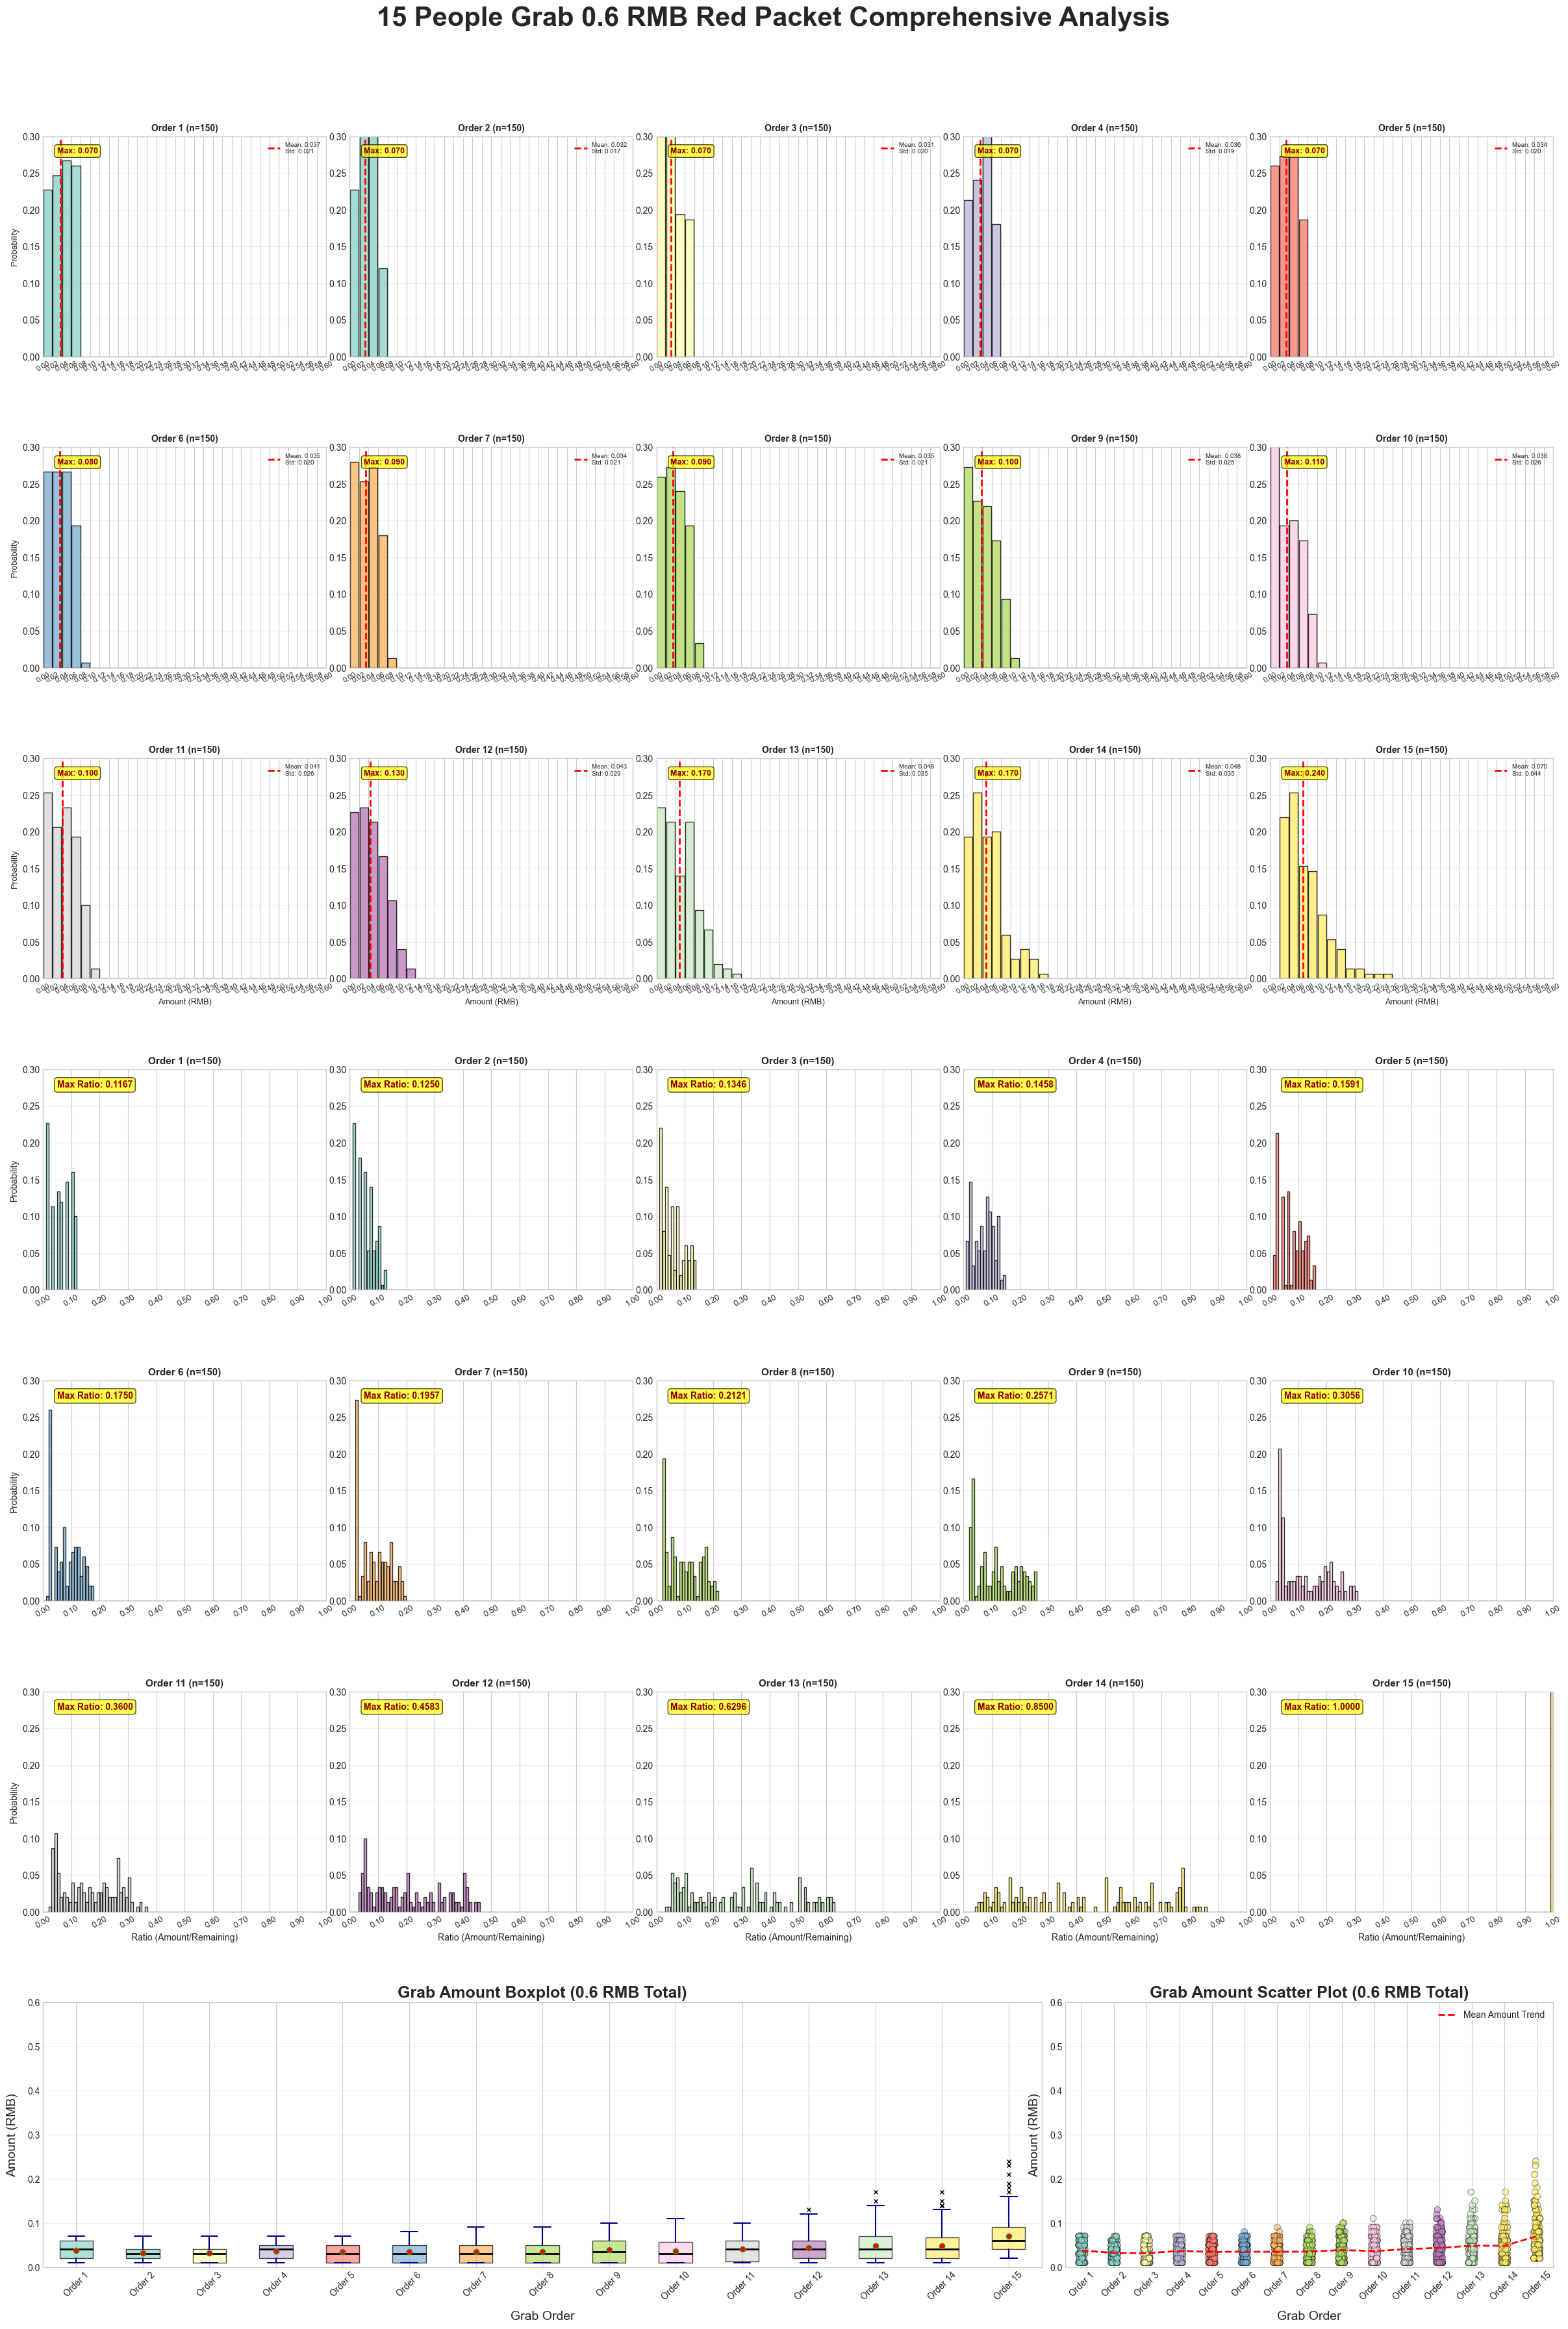

=== 15 People Grab 0.6 RMB Red Packet Statistics ===

1. Amount Statistics (RMB):
   Order  Sample Size  Mean   Std   Max
 Order 1          150 0.037 0.021 0.070
 Order 2          150 0.032 0.017 0.070
 Order 3          150 0.031 0.020 0.070
 Order 4          150 0.036 0.019 0.070
 Order 5          150 0.034 0.020 0.070
 Order 6          150 0.035 0.020 0.080
 Order 7          150 0.034 0.021 0.090
 Order 8          150 0.035 0.021 0.090
 Order 9          150 0.038 0.025 0.100
Order 10          150 0.036 0.026 0.110
Order 11          150 0.041 0.026 0.100
Order 12          150 0.043 0.029 0.130
Order 13          150 0.048 0.035 0.170
Order 14          150 0.048 0.035 0.170
Order 15          150 0.070 0.044 0.240

2. Ratio Statistics:
   Order  Sample Size Mean Ratio Max Ratio
 Order 1          150     0.0621    0.1167
 Order 2          150     0.0566    0.1250
 Order 3          150     0.0587    0.1346
 Order 4          150     0.0724    0.1458
 Order 5          150     0.0739    0.159

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, MaxNLocator
import random
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

DATA_PATH = "E:/gailvlun/SI140A-proj/Data/15/15人 0.6.xls"
df = pd.read_excel(DATA_PATH, sheet_name="Sheet1", header=None)

amount_data = df.iloc[1:-1, :15].values.astype(float).round(2)
total_per_round = df.iloc[1:-1, 15].values.astype(float).round(2) if df.shape[1] > 15 else np.nansum(amount_data, axis=1).round(2)
n_rounds = len(amount_data)
grab_order_labels = [f"Order {i+1}" for i in range(15)]

ratio_matrix = np.zeros_like(amount_data)
for round_idx in range(n_rounds):
    total = total_per_round[round_idx] if not np.isnan(total_per_round[round_idx]) else 0
    remaining = total
    for order_idx in range(15):
        amount = amount_data[round_idx, order_idx]
        if np.isnan(amount) or remaining <= 0:
            ratio = np.nan
        else:
            ratio = (amount / remaining).round(4)
        ratio_matrix[round_idx, order_idx] = ratio
        remaining -= amount

all_valid_amount = amount_data[~np.isnan(amount_data)]
global_min_amount = 0.0
global_max_amount = 0.6
all_valid_ratio = ratio_matrix[~np.isnan(ratio_matrix)]
global_min_ratio = 0.0
global_max_ratio = 1.0

fig = plt.figure(figsize=(30, 40))
gs = fig.add_gridspec(
    7, 15, 
    hspace=0.4, wspace=0.3,
    height_ratios=[1,1,1,1,1,1,1.2],
    width_ratios=[1]*15
)

fig.suptitle(
    "15 People Grab 0.6 RMB Red Packet Comprehensive Analysis",
    fontsize=30,
    fontweight="bold",
    y=0.98
)

colors = cm.Set3(np.linspace(0, 1, 15))

amount_axes = []
for i in range(3):
    for j in range(5):
        idx = i*5 + j
        if idx < 15:
            ax = fig.add_subplot(gs[i, j*3:(j+1)*3])
            amount_axes.append(ax)
        else:
            ax = fig.add_subplot(gs[i, j*3:(j+1)*3])
            ax.set_visible(False)

bin_width = 0.02
bin_edges = np.arange(global_min_amount, global_max_amount + bin_width, bin_width)
for idx, (ax, order_data, color) in enumerate(zip(amount_axes, amount_data.T, colors)):
    valid_data = order_data[~np.isnan(order_data)].round(2)
    total_samples = len(valid_data)
    if total_samples == 0:
        ax.set_visible(False)
        continue

    freq, _ = np.histogram(valid_data, bins=bin_edges)
    prob = freq / total_samples
    bin_centers = bin_edges[:-1] + bin_width / 2

    order_mean = np.mean(valid_data).round(3)
    order_std = np.std(valid_data).round(3)
    order_max = np.max(valid_data).round(3)

    ax.bar(
        bin_centers,
        prob,
        width=bin_width - 0.002,
        edgecolor="black",
        alpha=0.8,
        color=color,
    )
    ax.axvline(
        x=order_mean,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {order_mean:.3f}\nStd: {order_std:.3f}",
    )
    ax.annotate(
        f"Max: {order_max:.3f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=9,
        fontweight="bold",
        color="darkred",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
        ha="left",
        va="top",
    )
    ax.set_xlim(global_min_amount, global_max_amount)
    ax.xaxis.set_major_locator(MultipleLocator(0.02))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))
    ax.tick_params(axis="x", labelsize=8, rotation=30)
    ax.set_ylim(0, 0.3)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.set_title(f"{grab_order_labels[idx]} (n={total_samples})", fontsize=10, fontweight="bold")
    if idx % 5 == 0:
        ax.set_ylabel("Probability", fontsize=9)
    if idx >= 10:
        ax.set_xlabel("Amount (RMB)", fontsize=9)
    ax.legend(fontsize=7, loc="upper right")
    ax.grid(axis="y", alpha=0.3)

ratio_axes = []
for i in range(3, 6):
    for j in range(5):
        idx = (i-3)*5 + j
        if idx < 15:
            ax = fig.add_subplot(gs[i, j*3:(j+1)*3])
            ratio_axes.append(ax)
        else:
            ax = fig.add_subplot(gs[i, j*3:(j+1)*3])
            ax.set_visible(False)

bin_width_ratio = 0.01
bin_edges_ratio = np.arange(global_min_ratio, global_max_ratio + bin_width_ratio, bin_width_ratio)
for idx, (ax, order_ratio, color) in enumerate(zip(ratio_axes, ratio_matrix.T, colors)):
    valid_ratio = order_ratio[~np.isnan(order_ratio)]
    total_samples = len(valid_ratio)
    if total_samples == 0:
        ax.set_visible(False)
        continue

    freq, _ = np.histogram(valid_ratio, bins=bin_edges_ratio)
    prob = freq / total_samples
    bin_centers = bin_edges_ratio[:-1] + bin_width_ratio / 2

    ratio_mean = np.mean(valid_ratio).round(4)
    ratio_max = np.max(valid_ratio).round(4) if len(valid_ratio) > 0 else np.nan

    ax.bar(
        bin_centers,
        prob,
        width=bin_width_ratio - 0.001,
        edgecolor="black",
        alpha=0.8,
        color=color,
    )
    if not np.isnan(ratio_max):
        ax.annotate(
            f"Max Ratio: {ratio_max:.4f}",
            xy=(0.05, 0.95),
            xycoords="axes fraction",
            fontsize=10,
            fontweight="bold",
            color="darkred",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
            ha="left",
            va="top",
        )
    ax.set_xlim(global_min_ratio, global_max_ratio)
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))
    ax.tick_params(axis="x", labelsize=9, rotation=30)
    ax.set_ylim(0, 0.3)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.set_title(f"{grab_order_labels[idx]} (n={total_samples})", fontsize=11, fontweight="bold")
    if idx % 5 == 0:
        ax.set_ylabel("Probability", fontsize=10)
    if idx >= 10:
        ax.set_xlabel("Ratio (Amount/Remaining)", fontsize=10)
    ax.grid(axis="y", alpha=0.3)

ax_box = fig.add_subplot(gs[6, :10])
boxplot_data = [amount_data[:, i][~np.isnan(amount_data[:, i])] for i in range(15)]
bp = ax_box.boxplot(
    boxplot_data,
    tick_labels=grab_order_labels,
    patch_artist=True,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markersize": 6},
    medianprops={"color": "black", "linewidth": 2},
    whiskerprops={"color": "darkblue", "linewidth": 1.5},
    capprops={"color": "darkblue", "linewidth": 1.5},
    flierprops={"marker": "x", "markerfacecolor": "orange", "markersize": 5},
)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax_box.set_title("Grab Amount Boxplot (0.6 RMB Total)", fontsize=18, fontweight="bold")
ax_box.set_xlabel("Grab Order", fontsize=14, labelpad=10)
ax_box.set_ylabel("Amount (RMB)", fontsize=14, labelpad=10)
ax_box.set_ylim(global_min_amount, global_max_amount)
ax_box.tick_params(axis="x", rotation=45, labelsize=10)
ax_box.grid(axis="y", alpha=0.3)

ax_scatter = fig.add_subplot(gs[6, 10:])
x_data, y_data, colors_list = [], [], []
for i in range(15):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    x_jitter = [i + 1 + random.uniform(-0.1, 0.1) for _ in valid_amount]
    x_data.extend(x_jitter)
    y_data.extend(valid_amount)
    colors_list.extend([colors[i]] * len(valid_amount))

ax_scatter.scatter(
    x_data, y_data, c=colors_list, alpha=0.6, s=50, edgecolors="black", linewidths=0.5
)
x_trend = np.arange(1, 16)
y_trend = [np.nanmean(amount_data[:, i][~np.isnan(amount_data[:, i])]) for i in range(15)]
ax_scatter.plot(
    x_trend, y_trend, color="red", linewidth=2, linestyle="--", label="Mean Amount Trend"
)
ax_scatter.set_title("Grab Amount Scatter Plot (0.6 RMB Total)", fontsize=18, fontweight="bold")
ax_scatter.set_xlabel("Grab Order", fontsize=14, labelpad=10)
ax_scatter.set_ylabel("Amount (RMB)", fontsize=14, labelpad=10)
ax_scatter.set_xlim(0.5, 15.5)
ax_scatter.set_ylim(global_min_amount, global_max_amount)
ax_scatter.set_xticks(range(1, 16))
ax_scatter.set_xticklabels(grab_order_labels, rotation=45)
ax_scatter.legend(fontsize=10)
ax_scatter.grid(axis="y", alpha=0.3)

plt.subplots_adjust(top=0.93, hspace=0.4, wspace=0.3)
plt.savefig("15people_0.6rmb_comprehensive_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print("=== 15 People Grab 0.6 RMB Red Packet Statistics ===")
print("\n1. Amount Statistics (RMB):")
amount_stats = []
for i in range(15):
    valid_data = amount_data[:, i][~np.isnan(amount_data[:, i])]
    if len(valid_data) == 0:
        stats = {
            "Order": f"Order {i+1}",
            "Sample Size": 0,
            "Mean": "N/A",
            "Std": "N/A",
            "Max": "N/A"
        }
    else:
        stats = {
            "Order": f"Order {i+1}",
            "Sample Size": len(valid_data),
            "Mean": f"{np.mean(valid_data):.3f}",
            "Std": f"{np.std(valid_data):.3f}",
            "Max": f"{np.max(valid_data):.3f}"
        }
    amount_stats.append(stats)
print(pd.DataFrame(amount_stats).to_string(index=False))

print("\n2. Ratio Statistics:")
ratio_stats = []
for i in range(15):
    valid_ratio = ratio_matrix[:, i][~np.isnan(ratio_matrix[:, i])]
    if len(valid_ratio) == 0:
        stats = {
            "Order": f"Order {i+1}",
            "Sample Size": 0,
            "Mean Ratio": "N/A",
            "Max Ratio": "N/A"
        }
    else:
        stats = {
            "Order": f"Order {i+1}",
            "Sample Size": len(valid_ratio),
            "Mean Ratio": f"{np.mean(valid_ratio):.4f}",
            "Max Ratio": f"{np.max(valid_ratio):.4f}"
        }
    ratio_stats.append(stats)
print(pd.DataFrame(ratio_stats).to_string(index=False))

print("\n3. Mean Amount Trend:")
for i in range(15):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    mean_amount = np.nanmean(valid_amount) if len(valid_amount) > 0 else np.nan
    print(f"Order {i+1}: {mean_amount:.3f} yuan")

#### Conclusion 

1. Whether in 3-person or 15-person groups, the mean grab amount across different grabbing orders is close to the theoretical mean. This indicates that the core logic of red envelope allocation is random distribution around the theoretical mean, and the overall average amount is not affected by the grabbing order.

2. The later the grabbing order, the greater the amount dispersion: amounts of early grabbers are more concentrated (0-35 RMB for 3-person groups, 0-8 RMB for 15-person groups); amounts of later grabbers show significantly expanded fluctuations (0-55 RMB for 3-person groups, 0-18 RMB for 15-person groups), with a higher probability of extreme high amounts.


#### Suspect

1. The **upper limit** for the money that one player can get is **$M\frac{2}{n}$** (M is the rest money,n is the rest player)

2. The **lower limit** for the money that one player can get is **$M\frac{1}{5n}$** (M is the rest money,n is the rest player),if the allocated amount is less than the minimum limit, round up.

3. The **distribution** for each player is the **Money~Unif(0,$M\frac{2}{n}$)** (M is the rest money,n is the rest player)

### **3. Distribution Modeling**
Now we will analyze this distribution using a more rigorous method.

Combining the allocation logic of WeChat red envelopes, this study assumes that the received amount follows a **constrained scaled Beta distribution** (instead of the conventional normal distribution), and uses the Maximum Likelihood Method to infer the distribution parameters.


#### **3.1 Hidden Distribution Assumption**
The received amount of WeChat red envelopes is constrained by the "remaining amount before grabbing" and "remaining number of people". Thus, we assume that the **single-round received amount $out_i$ follows a scaled Beta distribution on the interval $[0, U_i]$**, where:

 $U_i = \frac{in_i \cdot c}{rem_i}$: The upper bound of the $i$-th received amount ($in_i$ is the remaining amount before grabbing, $rem_i$ is the remaining number of people, and $c$ is the boundary constant);

 The distribution parameter is $\theta = (\alpha, \beta, c)$: $\alpha, \beta$ are the shape parameters of the Beta distribution, and $c$ is the constraint parameter controlling the upper bound of the amount.


#### **3.2 Probability Density Function (PDF)**
The probability density function of the $i$-th received amount $out_i$ is:
$$f(out_i; \alpha, \beta, c) = \frac{out_i^{\alpha-1} \cdot (U_i - out_i)^{\beta-1}}{U_i^{\alpha+\beta-1} \cdot B(\alpha, \beta)}$$
where $B(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}$ is the Beta function, and $\Gamma(\cdot)$ is the Gamma function.


#### **3.3 Likelihood Function and Log-Likelihood Function**
Based on the independent observation assumption, the likelihood function for $N=2100$ samples is:
$$L(\alpha, \beta, c) = \prod_{i=1}^{2100} \frac{out_i^{\alpha-1} \cdot \left(\frac{in_i \cdot c}{rem_i} - out_i\right)^{\beta-1}}{\left(\frac{in_i \cdot c}{rem_i}\right)^{\alpha+\beta-1} \cdot B(\alpha, \beta)}$$

To simplify the optimization process, we take the natural logarithm of the likelihood function to obtain the log-likelihood function:
$$\ell(\alpha, \beta, c) = \sum_{i=1}^{2100} \left[ (\alpha-1)\ln(out_i) + (\beta-1)\ln\left(\frac{in_i \cdot c}{rem_i} - out_i\right) - (\alpha+\beta-1)\ln\left(\frac{in_i \cdot c}{rem_i}\right) - \ln B(\alpha, \beta) \right]$$


#### **3.4 Maximum Likelihood Estimation (MLE)**
The core of MLE is to find the parameter $\hat{\theta} = (\hat{\alpha}, \hat{\beta}, \hat{c})$ that maximizes the log-likelihood function (or minimizes the negative log-likelihood):
$$\hat{\theta} = \arg \max_{\alpha, \beta, c} \left\{ \sum_{i=1}^{2100} \left[ (\alpha-1)\ln(out_i) + (\beta-1)\ln\left(\frac{in_i \cdot c}{rem_i} - out_i\right) - (\alpha+\beta-1)\ln\left(\frac{in_i \cdot c}{rem_i}\right) - 2100 \cdot \ln B(\alpha, \beta) \right] \right\}$$


#### **3.5 Estimation Constraints**
To ensure the physical meaning of the parameters, the following constraints are imposed during optimization:
1. Shape parameter constraint: $\alpha > 0, \beta > 0$;
2. Boundary constant constraint: $0 < c \le 2$ (consistent with the "double-mean" allocation logic of red envelopes);
3. Amount rationality constraint: $c > \max_{i} \left( \frac{out_i \cdot rem_i}{in_i} \right)$ (ensuring that the actual received amount does not exceed the theoretical upper bound $U_i$).

Below is our code:

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import beta as beta_dist
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

file_path = "E:/gailvlun/SI140A-proj/Data/15/Christmas15-Dataset.xlsx"
df = pd.read_excel(file_path, header=None)

remaining_people = df.iloc[:, 0].values
in_i_values = df.iloc[:, 1].values
out_i_values = df.iloc[:, 2].values
n_data_points = len(remaining_people)

n_draws = 14
n_red_packets = n_data_points // n_draws
print(
    f"Data: {n_red_packets} red packets, {n_draws} draws per red packet, total {n_red_packets * n_draws} data points\n"
)


def negative_log_likelihood(params):
    alpha, beta_param, c = params

    if alpha <= 0 or beta_param <= 0 or c <= 0 or c > 2:
        return np.inf

    log_likelihood = 0

    for i in range(n_data_points):
        out_i = out_i_values[i]
        in_i = in_i_values[i]
        remaining = remaining_people[i]

        if remaining <= 0 or in_i <= 0 or out_i <= 0:
            continue

        max_amount = c * in_i / remaining
        if out_i >= max_amount:
            return np.inf

        y_i = out_i / max_amount
        if y_i <= 1e-10 or y_i >= 1 - 1e-10:
            return np.inf

        log_pdf = beta_dist.logpdf(y_i, alpha, beta_param)
        log_pdf -= np.log(max_amount)

        if not np.isfinite(log_pdf):
            return np.inf

        log_likelihood += log_pdf

    return -log_likelihood


initial_guesses = [
    [0.5, 0.5, 2.0],
    [0.8, 0.8, 2.0],
    [1.0, 1.0, 2.0],
    [1.2, 1.2, 2.0],
    [1.5, 1.5, 2.0],
    [2.0, 2.0, 2.0],
    [3.0, 3.0, 2.0],
    [1.0, 1.5, 2.0],
    [1.5, 1.0, 2.0],
    [1.0, 2.0, 2.0],
    [2.0, 1.0, 2.0],
    [1.0, 1.0, 1.8],
    [1.0, 1.0, 1.9],
    [1.5, 1.5, 1.9],
    [2.0, 2.0, 1.9],
]

print("=== Start MLE Optimization ===\n")

bounds = [(0.01, 50), (0.01, 50), (0.01, 2.0)]
results = []

for init_idx, initial_guess in enumerate(initial_guesses):
    print(
        f"Initial guess {init_idx+1}: α={initial_guess[0]}, β={initial_guess[1]}, c={initial_guess[2]}"
    )
    try:
        result = minimize(
            negative_log_likelihood,
            initial_guess,
            method="L-BFGS-B",
            bounds=bounds,
            options={"maxiter": 15000, "ftol": 1e-10},
        )
        if result.success:
            results.append(result)
            print(
                f"Optimization result: α={result.x[0]:.6f}, β={result.x[1]:.6f}, c={result.x[2]:.6f}, NLL={result.fun:.4f}"
            )
        else:
            print(f"Optimization result: Failed")
    except:
        print(f"Optimization result: Failed")
    print()

if len(results) == 0:
    raise ValueError("All optimizations failed")

best_opt = min(results, key=lambda x: x.fun)

print("\n" + "=" * 60)
print("=== MLE Estimation Results ===")
print("=" * 60)
print(f"\nParameter estimates:")
print(f"  alpha = {best_opt.x[0]:.6f}")
print(f"  beta  = {best_opt.x[1]:.6f}")
print(f"  c     = {best_opt.x[2]:.6f}")
print(f"Negative log-likelihood value: {best_opt.fun:.4f}")

Data: 150 red packets, 14 draws per red packet, total 2100 data points

=== Start MLE Optimization ===

Initial guess 1: α=0.5, β=0.5, c=2.0
Optimization result: α=0.500000, β=0.500000, c=2.000000, NLL=4650.4131

Initial guess 2: α=0.8, β=0.8, c=2.0
Optimization result: α=0.800000, β=0.800000, c=2.000000, NLL=4359.0301

Initial guess 3: α=1.0, β=1.0, c=2.0
Optimization result: α=1.000000, β=1.000000, c=2.000000, NLL=4308.9077

Initial guess 4: α=1.2, β=1.2, c=2.0
Optimization result: α=1.061666, β=1.061666, c=2.000000, NLL=4306.9860

Initial guess 5: α=1.5, β=1.5, c=2.0
Optimization result: α=0.985751, β=0.985751, c=2.000000, NLL=4310.1314

Initial guess 6: α=2.0, β=2.0, c=2.0
Optimization result: α=1.063236, β=1.061916, c=2.000000, NLL=4306.8925

Initial guess 7: α=3.0, β=3.0, c=2.0
Optimization result: α=1.154353, β=1.154353, c=2.000000, NLL=4313.2695

Initial guess 8: α=1.0, β=1.5, c=2.0
Optimization result: α=0.978485, β=0.866839, c=2.000000, NLL=4322.6699

Initial guess 9: α=1.5, 

<div style="border: 2px solid #333; padding: 20px; width: 70%; margin: 0 auto; border-radius: 8px;">

### **Code Explanation**

In our implementation, we use scipy.optimize.minimize to find the parameter set $\hat{\theta} = (\hat{\alpha}, \hat{\beta}, \hat{c})$. 

1. Minimize the "Negative" Log-Likelihood
The goal of MLE is to find the parameters that maximize the joint probability of observing our data:
$$\hat{\theta} = \arg \max_{\theta} \mathcal{L}(\theta)$$
However, most numerical optimization libraries (including scipy.optimize) are designed as minimizers. Mathematically, maximizing a function $f(x)$ is equivalent to minimizing its negative $-f(x)$.
Therefore, we define our objective function as the Negative Log-Likelihood (NLL):
$$\text{NLL}(\alpha, \beta, c) = - \sum_{i=1}^{N} \log[f(out_i; \alpha, \beta, c)]$$
In the code, return -log_likelihood transforms the maximization problem into a minimization task that the L-BFGS-B algorithm can solve.

2. The Complexity of Analytical Derivatives
To solve for $\hat{\alpha}$ and $\hat{\beta}$ analytically, we would need to set the partial derivatives of the log-likelihood to zero. For a Beta distribution, the log-likelihood involves the Beta function $B(\alpha, \beta)$, whose derivative involves the digamma function $\psi(x) = \frac{d}{dx} \ln \Gamma(x)$:


$$\frac{\partial \ell}{\partial \alpha} = \sum \ln(y_i) - N(\psi(\alpha) - \psi(\alpha+\beta)) = 0$$

These equations are transcendental, meaning they cannot be solved for $\alpha$ and $\beta$ using basic algebra. They require iterative numerical methods anyway.Bby using scipy.optimize.minimize, we let the computer handle the root-finding through gradient-based search.

3. Handling Constraints and Boundaries
Directly setting derivatives to zero does not account for parameter constraints. Our model has strict requirements:
**$\alpha > 0, \beta > 0$ and $c > 0$ and upper bound $U_i$ must be greater than the observed $out_i$.**
The L-BFGS-B algorithm used in the code is specifically designed to handle bounds (e.g., bounds = [(0.01, 50), ... ]). It ensures that the search stays within valid mathematical territory, preventing the code from crashing due to $\log(\text{negative number})$ or invalid Beta parameters.
This constraint can be linked to the phenomenon we observed earlier in Part 2 Visualization -> Because 7.99 exists, c must be greater than 7.99/8 * 2 -> This provides a basis for starting our optimization from around c = 2. At the same time, considering that when there are only two people left, it becomes c/2, so c should be <= 2.

4. Efficiency with Large Datasets ($N=2100$)
With 2100 data points, calculating the exact Hessian matrix (second-order derivatives) for Newton's method would be computationally expensive. L-BFGS-B is a "Limited-memory" quasi-Newton method; it approximates the curvature of the likelihood surface efficiently using only the gradient, making it ideal for datasets of this size.

##### **Summary**

1. Numerical optimization achieves MLE parameter estimation by minimizing the negative log-likelihood, avoiding the complexity of solving transcendental equations analytically; 
1. The L-BFGS-B algorithm naturally supports parameter boundary constraints, ensuring that the optimization process complies with physical/domain constraints; 
1. Its limited memory feature makes L-BFGS-B more efficient than Hessian-based Newton methods for large datasets (N=2100).

</div>

After the model ,we can find $\alpha\approx 1$,$\beta\approx 1$,$c\approx 2$,the distribution is close to **uniform distribution on the interval[0,$\frac{in_i \cdot c}{rem_i}$]**.It also aligns with our guesses about the distribution based on observing the images.

#### Conclusion

We can conclude that the order in which people grab red envelopes on WeChat follows that the i-th person receives an amount according to **$X_i$ ~ $Unif(0, \frac{in_i \cdot c}{n-i+1})$.**

($in_i$ is the remaining amount before grabbing)

## **4.Model Testing**

## **5.Generative Modeling**

## **6.From Modeling to Decision-Making Policy**

### Proof of the "Double Mean" Red Packet Algorithm

The **Double Mean Method** is a common algorithm used to distribute a total amount $S$ among $n$ people such that the expectation for each person is equal.

---

### 1. Problem Definition
Let:
* $S$: Total amount of money.
* $n$: Total number of participants.
* $X_k$: Random variable representing the amount received by the $k$-th person.
* $S_k$: Remaining amount when the $k$-th person draws ($S_1 = S$).
* $n_k$: Remaining number of people when the $k$-th person draws ($n_k = n - k + 1$).

The algorithm defines $X_k$ as a uniform distribution:
$$X_k \sim U\left(0, \frac{2S_k}{n_k}\right)$$

We aim to prove that $E[X_k] = \frac{S}{n}$ for all $k \in \{1, 2, \dots, n\}$.

---

### 2. Mathematical Proof by Induction

#### Step 1: Base Case ($k=1$)
For the first person, $S_1 = S$ and $n_1 = n$. The amount $X_1$ follows $U(0, \frac{2S}{n})$.
The expectation of a uniform distribution $U(a, b)$ is $\frac{a+b}{2}$:
$$E[X_1] = \frac{0 + \frac{2S}{n}}{2} = \frac{S}{n}$$
The base case holds.

#### Step 2: Inductive Hypothesis
Assume that for the first $k$ people, the expected value for each is:
$$E[X_1] = E[X_2] = \dots = E[X_k] = \frac{S}{n}$$

#### Step 3: Inductive Step
We need to prove $E[X_{k+1}] = \frac{S}{n}$. 
The remaining amount for the $(k+1)$-th person is:
$$S_{k+1} = S - \sum_{i=1}^{k} X_i$$

Taking the expectation of $S_{k+1}$ based on our hypothesis:
$$E[S_{k+1}] = S - \sum_{i=1}^{k} E[X_i] = S - k \cdot \frac{S}{n} = S \left( \frac{n-k}{n} \right)$$

According to the **Law of Iterated Expectations**:
$$E[X_{k+1}] = E\left[ E[X_{k+1} | S_{k+1}] \right]$$

Given $S_{k+1}$, the conditional expectation is:
$$E[X_{k+1} | S_{k+1}] = \frac{1}{2} \left( \frac{2S_{k+1}}{n_{k+1}} \right) = \frac{S_{k+1}}{n - k}$$

Substitute this back into the total expectation formula:
$$E[X_{k+1}] = E\left[ \frac{S_{k+1}}{n - k} \right] = \frac{1}{n - k} E[S_{k+1}]$$

Finally, substitute the expression for $E[S_{k+1}]$:
$$E[X_{k+1}] = \frac{1}{n - k} \cdot S \left( \frac{n-k}{n} \right) = \frac{S}{n}$$

---

### 3. Conclusion
By mathematical induction, we have proven that for any $k$:
$$E[X_k] = \frac{S}{n}$$
This ensures the algorithm is **fair in expectation**, regardless of the drawing order.

## **7.Further Explorations**